In [6]:
import pandas as pd
import math
import json
import numpy as np
import random
random.seed(1)
import configparser
NORMALIZATION = True
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
class Chromosome:
    def __init__(self, genes, length):
        self.genes = genes
        self.length = length
        self.fitness = 0

    def randomGenerateChromosome(self):
        for i in range(0, self.length, +1):
            gen = float('%.2f' % random.uniform(0.0, 1.0))
            self.genes.append(gen)

        return self



pd.options.mode.chained_assignment = None

class Point:
    def __init__(self, pattern_id):
        self.length = len(pattern_id)
        self.pattern_id = pattern_id
        self.z = -1

    def __str__(self):
        return str(self.pattern_id)

    def toJSON(self):
        return {
            'pattern_id':self.pattern_id
        }


class Cluster:
    def __init__(self, dim, centroid):
        self.dim = dim
        self.centroid = centroid
        self.points = []
        self.distances = []

    def computeS(self):
        n = len(self.points)
        if n == 0:
            return 0
        s = 0
        for x in self.distances:
            s += x
        return float(s / n)



class Clustering:
    def __init__(self, generation, data, kmax):
        self.generation = generation
        self.data = data
        self.dim = data.shape[1]
        self.penalty = 1000000
        self.kmax = kmax

    def daviesBouldin(self, clusters):
        sigmaR = 0.0
        nc = len(clusters)
        for i in range(nc):
            sigmaR = sigmaR + self.computeR(clusters)
            #print(sigmaR)
        DBIndex = float(sigmaR) / float(nc)
        return DBIndex

    def computeR(self, clusters):
        listR = []
        for i, iCluster in enumerate(clusters):
            for j, jCluster in enumerate(clusters):
                if(i != j):
                    temp = self.computeRij(iCluster, jCluster)
                    listR.append(temp)
        return max(listR)

    def computeRij(self, iCluster, jCluster):
        Rij = 0

        d = self.euclidianDistance(
            iCluster.centroid, jCluster.centroid)
        #print("d",d)
        #print("icluster",iCluster.computeS())
        Rij = (iCluster.computeS() + jCluster.computeS()) / d

        #print("Rij:", Rij)
        return Rij

    def euclidianDistance(self, point1, point2):
        sum = 0
        for i in range(0, point1.length):
            square = pow(
                point1.pattern_id[i] - point2.pattern_id[i], 2)
            sum += square

        sqr = math.sqrt(sum)
        return sqr

    def calcDistance(self, clusters):
        kmax = self.kmax
        dim = self.dim
        data = self.data
        dis = 0
        disSet = []

        for z in range(data.shape[0]):
            point = Point(data.loc[z][0:dim])
            point.z = z

            for i in range(kmax):
                dis = self.euclidianDistance(clusters[i].centroid, point)
                disSet.append(dis)
                dis = 0

            clusters = self.findMin(
                disSet, clusters, point)
            disSet = []  # clear disSet	# calculate distance

        return clusters

    def findMin(self, disSet, clusters, point):
        n = disSet.index(min(disSet))  # n is index
        minDis = disSet[n]
        clusters[n].points.append(point)
        clusters[n].distances.append(minDis)

        return clusters

    # childChromosome, kmax
    def calcChildFit(self, childChromosome):
        kmax = self.kmax
        dim = self.dim
        clusters = []
        for j in range(kmax):
            point = Point(childChromosome.genes[j * dim: (j + 1) * dim])
            clusters.append(Cluster(dim, point))

        clusters = self.calcDistance(clusters)
        DBIndex = self.daviesBouldin(clusters)

        childChromosome.fitness = 1 / DBIndex

        return childChromosome

    def calcChromosomesFit(self):
        kmax = self.kmax
        generation = self.generation
        numOfInd = generation.numberOfIndividual
        data = self.data
        chromo = generation.chromosomes

        for i in range(0, numOfInd):

            dim = self.dim
            clusters = []
            for j in range(kmax):
                point = Point(chromo[i].genes[j * dim: (j + 1) * dim])
                clusters.append(Cluster(dim, point))


            clusters = self.calcDistance(clusters)
            DBIndex = self.daviesBouldin(clusters)
            generation.chromosomes[i].fitness = 1 / DBIndex

        return generation

    def printIBest(self, iBest):
        kmax = self.kmax
        dim = self.dim
        clusters = []
        for j in range(kmax):
            point = Point(iBest.genes[j * dim: (j + 1) * dim])
            clusters.append(Cluster(dim, point))

        clusters = self.calcDistance(clusters)
        DBIndex = self.daviesBouldin(clusters)
        z = (np.zeros(150)).tolist()
        for i, cluster in enumerate(clusters):
            for j in cluster.points:
                z[j.z] = i

        correct_answer = 0
        for i in range(0, 50):
            if z[i] == 2:
                correct_answer += 1
        for i in range(50, 100):
            if z[i] == 1:
                correct_answer += 1
        for i in range(100, 150):
            if z[i] == 0:
                correct_answer += 1

        accuracy = (correct_answer / 150) * 100

        print("accuracy :", accuracy)
        print("iBest Fitness:", 1 / DBIndex)
        print("all index:", z)
        print("Clusters centroid:")
        for i, cluster in enumerate(clusters):
            print("centroid", i, " :", cluster.centroid)

    def output_result(self, iBest, data):
        print("Saving the result...")
        kmax = self.kmax
        dim = self.dim
        clusters = []
        for j in range(kmax):
            point = Point(iBest.genes[j * dim: (j + 1) * dim])
            clusters.append(Cluster(dim, point))

        clusters = self.calcDistance(clusters)
        centroids = []
        for i in range(kmax):
            centroids.append(clusters[i].centroid)
        z = (np.zeros(150)).tolist()
        for i, cluster in enumerate(clusters):
            for j in cluster.points:
                z[j.z] = i

        with open('cluster_center.json', 'w') as outfile:
            json.dump([e.toJSON() for e in centroids], outfile, sort_keys=True,
                      indent=4, separators=(',', ': '))

        # rename df header
        col_name = list()
        for i in range(data.shape[1]):
            col_name.append("f{0}".format(i))
        data.columns = col_name

        # insert cluster result
        data['Cluster Index'] = pd.Series(z, index=data.index)
        data.to_csv('result.csv', index=None)
        print("Done.")

class Generation:
    def __init__(self, numberOfIndividual, generationCount):
        self.numberOfIndividual = numberOfIndividual
        self.chromosomes = []
        self.generationCount = generationCount

    def sortChromosomes(self):
        self.chromosomes = sorted(
            self.chromosomes, reverse=True, key=lambda elem: elem.fitness)
        return self.chromosomes

    def randomGenerateChromosomes(self, lengthOfChromosome):
        for i in range(0, self.numberOfIndividual):
            chromosome = Chromosome([], lengthOfChromosome)
            chromosome.randomGenerateChromosome()
            self.chromosomes.append(chromosome)


class Genetic:
    def __init__(self, numberOfIndividual, Ps, Pm, Pc, budget, data, generationCount, kmax):
        self.numberOfIndividual = numberOfIndividual
        self.Ps = Ps
        self.Pm = Pm
        self.Pc = Pc
        self.budget = budget
        self.data = data
        self.generationCount = generationCount
        self.kmax = kmax

    def geneticProcess(self, generation):
        budget = self.budget
        Ps = self.Ps
        Pm = self.Pm
        Pc = self.Pc
        numOfInd = self.numberOfIndividual

        print("------------Generation:",
              self.generationCount, "-----------------")
        generation.sortChromosomes()

        # ------------------------simple ranking selection------------------------

        generation = self.selection(generation)

        #  ------------------------------Crossover---------------------------------

        generation = self.crossover(generation)

        #  ------------------------------Mutation---------------------------------

        generation = self.mutation(generation)

        self.generationCount += 1
        return generation, self.generationCount

    def selection(self, generation):
        numOfInd = self.numberOfIndividual
        Ps = self.Ps

        # replace the worst Ps*numOfInd individual with the best Ps*numOfInd individual
        for i in range(0, int(Ps * numOfInd)):
            generation.chromosomes[numOfInd -
                                   1 - i] = generation.chromosomes[i]

        # sort chromosomes after ranking selection
        generation.sortChromosomes()
        return generation

    def crossover(self, generation):
        numOfInd = self.numberOfIndividual
        Pc = self.Pc

        index = random.sample(
            range(0, numOfInd - 1), int(Pc * numOfInd))

        for i in range(int(len(index) / 2),+2):  # do how many time
            generation = self.doCrossover(
                generation, i, index)

        generation.sortChromosomes()

        return generation

    def doCrossover(self, generation, i, index):

        chromo = generation.chromosomes
        length = chromo[0].length
        cut = random.randint(1, length - 1)
        parent1 = chromo[index[i]]
        parent2 = chromo[index[i + 1]]
        genesChild1 = parent1.genes[0:cut] + parent2.genes[cut:length]
        genesChild2 = parent1.genes[cut:length] + parent2.genes[0:cut]
        child1 = Chromosome(genesChild1, len(genesChild1))
        child2 = Chromosome(genesChild2, len(genesChild2))

        # ----clustering----
        clustering = Clustering(generation, self.data, self.kmax)
        child1 = clustering.calcChildFit(child1)
        child2 = clustering.calcChildFit(child2)
        # -------------------

        listA = []
        listA.append(parent1)
        listA.append(parent2)
        listA.append(child1)
        listA.append(child2)
        # sort parent and child by fitness / dec
        listA = sorted(listA, reverse=True,
                       key=lambda elem: elem.fitness)

        generation.chromosomes[index[i]] = listA[0]
        generation.chromosomes[index[i + 1]] = listA[1]

        return generation

    def mutation(self, generation):
        numOfInd = self.numberOfIndividual
        fitnessList = []
        generationAfterM = Generation(numOfInd, generation.generationCount)
        flagMutation = (np.zeros(numOfInd)).tolist()

        for i in range(numOfInd):
            temp = generation.chromosomes[i]
            fitnessList.append(temp.fitness)

        for i in range(numOfInd):
            if i == 0:  # Ibest doesn't need mutation
                generationAfterM.chromosomes.append(generation.chromosomes[0])
                flagMutation[0] = 0
            else:
                generationAfterM = self.doMutation(
                    generation.chromosomes[i],	generationAfterM, flagMutation, fitnessList, i)

        generationAfterM.sortChromosomes()
        return generationAfterM

    def doMutation(self, chromosomeBeforeM, generationAfterM, flagMutation, fitnessList, i):
        Pm = self.Pm
        dice = []
        length = len(chromosomeBeforeM.genes)
        chromosome = Chromosome([], length)
        geneFlag = []

        for j in range(length):
            dice.append(float('%.2f' % random.uniform(0.0, 1.0)))
            if dice[j] > Pm:
                chromosome.genes.append(chromosomeBeforeM.genes[j])
                geneFlag.append(0)

            if dice[j] <= Pm:
                chromosome.genes.append(
                    float('%.2f' % random.uniform(0.0, 1.0)))
                geneFlag.append(1)

        check = sum(geneFlag)

        if check == 0:
            flagMutation[i] = 0
            chromosome.fitness = fitnessList[i]
        else:
            flagMutation[i] = 1

            #---clustering----
            clustering = Clustering(chromosomeBeforeM, self.data, self.kmax)
            chromosome = clustering.calcChildFit(
                chromosome)
            #------------------

        generationAfterM.chromosomes.append(chromosome)
        return generationAfterM





def readVars(config_file):
    config = configparser.ConfigParser()
    config.read(config_file)
    budget = int(config.get("vars", "budget"))
    kmax = int(config.get("vars", "kmax"))  # Maximum number of Clusters
    numOfInd = int(config.get("vars", "numOfInd"))  # number of individual
    Ps = float(config.get("vars", "Ps"))
    Pm = float(config.get("vars", "Pm"))
    Pc = float(config.get("vars", "Pc"))

    return budget, kmax, Ps, Pm, Pc, numOfInd


# minmax normalization
def minmax(data):
    normData = data
    data = data.astype(float)
    normData = normData.astype(float)
    for i in range(0, data.shape[1]):
        tmp = data.iloc[:, i]
        # max of each column
        maxElement = np.amax(tmp)
        # min of each column
        minElement = np.amin(tmp)

        # norm_dat.shape[0] : size of row
        for j in range(0, normData.shape[0]):
            normData[i][j] = float(
                data[i][j] - minElement) / (maxElement - minElement)

    normData.to_csv('norm_data.csv', index=None, header=None)
    return normData

if __name__ == '__main__':
    config_file = "config.txt"
    if(NORMALIZATION):
        data = pd.read_csv('iris.csv', header=None)
        data = minmax(data)  # normalize
    else:
        data = pd.read_csv('norm_data.csv', header=None)
    # size of column
    dim = data.shape[1]

    # kmeans parameters & GA parameters
    generationCount = 0
    budget, kmax, Ps, Pm, Pc, numOfInd = readVars(config_file)

    print("-------------GA Info-------------------")
    print("budget", budget)
    print("kmax", kmax)
    print("numOfInd", numOfInd)
    print("Ps", Ps)
    print("Pm", Pm)
    print("Pc", Pc)
    print("---------------------------------------")

    # dim or pattern id
    chromosome_length = kmax * dim

    #-------------------------------------------------------#
    # 							main 						#
    #-------------------------------------------------------#
    initial = Generation(numOfInd, 0)
    initial.randomGenerateChromosomes(
        chromosome_length)  # initial generate chromosome

    clustering = Clustering(initial, data, kmax)  # eval fit of chromosomes

    # ------------------calc fitness------------------#
    generation = clustering.calcChromosomesFit()

    # ------------------------GA----------------------#
    while generationCount <= budget:
        GA = Genetic(numOfInd, Ps, Pm, Pc, budget, data, generationCount, kmax)
        generation, generationCount = GA.geneticProcess(
            generation)
        iBest = generation.chromosomes[0]
        clustering.printIBest(iBest)

    # ------------------output result-------------------#
    clustering.output_result(iBest, data)

-------------GA Info-------------------
budget 200
kmax 3
numOfInd 20
Ps 0.2
Pm 0.02
Pc 0.8
---------------------------------------
------------Generation: 0 -----------------
accuracy : 66.66666666666666
iBest Fitness: 0.9646948660089878
all index: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 1, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Clusters centroid:
centroid 0  : [0.88, 0.31, 0.86]
centroid 1  : [0.31, 0.94, 0.74]
centroid 2  : [0.42, 0.25, 0.01]
------------Generation: 1 -----------------
accuracy : 66.66666666666666
iBest Fitness: 0.9646948660089878
all index: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,

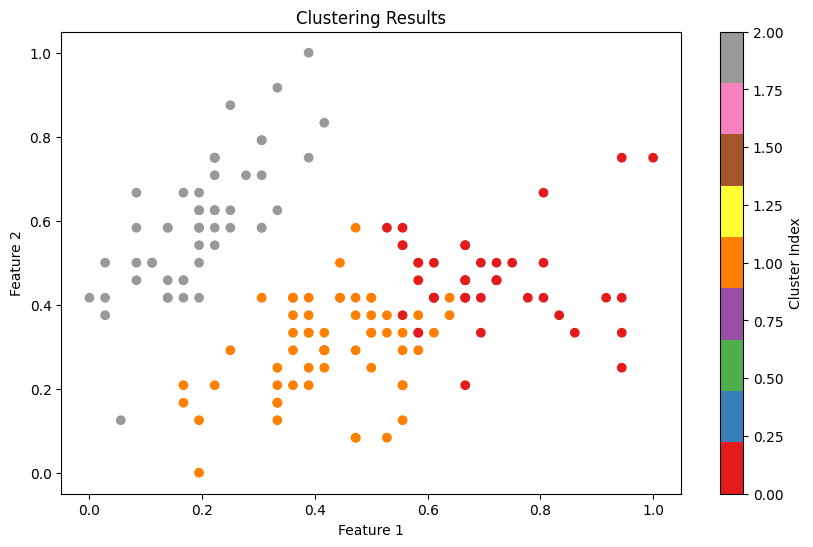

In [8]:
data = pd.read_csv('norm_data.csv', header=None).values
data.shape

z = pd.read_csv('result.csv')['Cluster Index']

plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], c=z, cmap='Set1')
plt.title('Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Index')
plt.show()

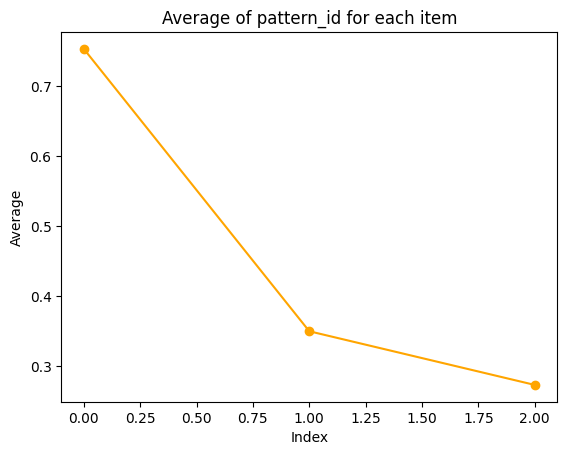

In [9]:
with open('cluster_center.json') as f:
    data = json.load(f)
averages = []

for item in data:
    pattern_id = item['pattern_id']
    avg = sum(pattern_id) / len(pattern_id)
    averages.append(avg)

plt.plot(averages, marker='o', color='orange')
plt.xlabel('Index')
plt.ylabel('Average')
plt.title('Average of pattern_id for each item')
plt.show()


In [15]:
import math # to initialize minimum to infinity
from collections import defaultdict # dictionary of lists
import numpy as np # for generating random weights in large graph
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # to show graph
import random
import networkx as nx

In [19]:
def initialize_population(nodes,pop_size):
    max_nod_num = max(nodes)
    population = []
    for i in range(pop_size):
        chromosome = []
        # to create a fully connected path
        while len(chromosome)!=len(nodes):
            rand_node = np.random.randint(max_nod_num+1)
            # to prevent repeted additions of nodes in the same chrromosome
            if rand_node not in chromosome:
                chromosome.append(rand_node)
        population.append(chromosome)
    return population

In [21]:
def cost(graph_edges,chromosome):
    total_cost=0
    i=1
    while i<len(chromosome):
        for temp_edge in graph_edges:
            if chromosome[i-1]==temp_edge[0] and chromosome[i]==temp_edge[1]:
                total_cost=total_cost+temp_edge[2]
        i=i+1
    for temp_edge in graph_edges:
            if chromosome[0]==temp_edge[0] and chromosome[len(chromosome) - 1]==temp_edge[1]:
                total_cost=total_cost+temp_edge[2]
    return total_cost

In [22]:
def select_best(parent_gen,graph_edges,elite_size):
    costs = []
    selected_parent = []
    pop_fitness = []
    for i in range(len(parent_gen)):
        costs.append(cost(graph_edges,parent_gen[i]))
        pop_fitness.append((costs[i],parent_gen[i]))
    #sort according to path_costs
    pop_fitness.sort(key = lambda x: x[0])
    # select only top elite_size fittest chromosomes in the population
    for i in range(elite_size):
        selected_parent.append(pop_fitness[i][1])
    return selected_parent,pop_fitness[0][0],selected_parent[0]

In [23]:
def breed(parent1, parent2):

    # let's say to breed from two parents (0,1,2,3,4) and (1,3,2,0,4)
    # if we choose parent1(0-2) i.e (0,1,2) then we have to choose (3,4) from parent2
    # i.e we have to create two children from two parents which are disjoint w.r.t each other
    child = []
    childP1 = []
    childP2 = []

    #select two random numbers between range(0,len(parents)) which are used as index
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    #define start and end index to select child1 from parent1
    if geneA < geneB :
        startGene, endGene = geneA, geneB
    else :
        endGene, startGene = geneA, geneB

    #add parent1(startGene,endGene) to child1
    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    #add parent2 to child2 if parent2 not in child1
    childP2 = [item for item in parent2 if item not in childP1]

    #create new child using disjoint Child1 and Child2
    child = childP1 + childP2
    return child

def breedPopulation(parents, pop_size):
    children = []
    temp = np.array(parents)
    n_parents = temp.shape[0]
    #create new population of size pop_size from previous population
    for i in range(pop_size):
        #choose random parents
        random_dad = parents[np.random.randint(low =0,high = n_parents - 1)]
        random_mom = parents[np.random.randint(low =0,high = n_parents - 1)]
        #create child using random parents
        children.append(breed(random_dad,random_mom))
    return children

In [24]:
def mutate(parent, n_mutations):
    # we cannot randomly change a node from chromosome to another node
    # as this will create repeated nodes
    # we define mutation as mutation of edges in the path i.e swapping of
    #nodes in the chromosome
    temp_parent = np.array(parent)
    size1 = temp_parent.shape[0]
    max_nod_num = max(parent)
    for i in range(n_mutations):
        # choose random indices to swap nodes in a chromosome
        rand1 = np.random.randint(0,size1)
        rand2 = np.random.randint(0,size1)
        # if rand1 and rand2 are same, then chromosome won't be mutated
        # so change rand2
        if rand1 == rand2:
            rand2=(rand2+1)%size1
        parent[rand1],parent[rand2]=parent[rand2],parent[rand1]
    return parent


def mutatePopulation(population, n_mutations):
    mutatedPop = []
    #mutate population
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], n_mutations)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [25]:
# class that represents a graph
class Graph:

    def __init__(self, vertices):
        self.nodes = []  # list of nodes
        for i in range(len(vertices)):
            self.nodes.append(vertices[i])
        self.edges = []  # to store graph
        # dictionary with the lists of successors of each node, faster to get the successors
        # each item of list is a 2-tuple: (destination, weight)
        self.successors = defaultdict(list)



    # function that adds edges
    def addEdge(self,u,v,w):
        for edges in self.edges:
            #check if edge is already present
            if u==edges[0] and v==edges[1]:
                print("Edge already exists")
                return
        self.edges.append([u,v,w])
        self.successors[u].append((v, w))

    # function to get the cost of optimal path found
    def get_cost(self,visited_nodes):
        if len(visited_nodes)<=1:
            return 0
        else:
            total_cost=0
            i=1
            while i<len(visited_nodes):
                for temp_edge in self.edges:
                    if visited_nodes[i-1]==temp_edge[0] and visited_nodes[i]==temp_edge[1]:
                        total_cost=total_cost+temp_edge[2]
                i=i+1
            for temp_edge in self.edges:
                    if visited_nodes[0]==temp_edge[0] and visited_nodes[len(visited_nodes) - 1]==temp_edge[1]:
                        total_cost=total_cost+temp_edge[2]
            return total_cost

    def disconnected(self,initial_node):
        is_disconnected = False
        for node in range(len(self.nodes)):
            neighbors = self.successors[node]
            # graph is fully connected if number of neighbours of eache node will be 1 less than total
            # number of nodes in the graph
            if len(neighbors) < (len(self.nodes)-1):
                is_disconnected = True
                return is_disconnected
        return is_disconnected
    def gen_algo(self,source,generations):
        #check if a graph is fully connected
        if self.disconnected(source):
            print("Graph is not connected")
            return []
        #initialize population with a certain size
        pop_size = 20
        parent_gen = initialize_population(self.nodes,pop_size)
        print(parent_gen)
        # keep the track of minimum path cost for each generation
        overall_costs = []
        # keep track of best route with minimum path cost for each generation
        overall_routes = []
        for i in range(generations):
            print("Generation number :",i+1,"/",generations)
            # choose only elite chromosome from population
            elite_size = 10
            parent_gen,min_cost,best_route = select_best(parent_gen,self.edges,elite_size)
            print("Best route for generation",i+1,":",best_route)
            print("Best cost for generation",i+1,":",min_cost)
            # store minimum path cost and best route for every generation
            overall_costs.append(min_cost)
            overall_routes.append(best_route)
            #mating
            parent_gen = breedPopulation(parent_gen,pop_size)
            #mutating
            n_mutations=1
            parent_gen = mutatePopulation(parent_gen,n_mutations)
            print("=============================================================================================================")
        #select the minimum path_cost
        minimum = min(overall_costs)
        min_index=-1
        #find the path with minimum path_cost from stored overall_routes
        for i in range(len(overall_costs)):
            if minimum == overall_costs[i]:
                min_index = i
        #return best route
        return overall_routes[min_index]

In [26]:
def print_path(path, source):
    print("=================Path found=================")
    print("final path:")
    start = path.index(source)
    for i in range(start, len(path) - 1):
        print(path[i], "->", path[i + 1])
    print(path[len(path) - 1], "->", path[0])
    for i in range(0, start):
        print(path[i], "->", path[i + 1])


In [27]:
g = Graph([0,1,2,3,4])


g.addEdge(0, 1, 29)
g.addEdge(0, 2, 20)
g.addEdge(0, 3, 21)
g.addEdge(0, 4, 16)

g.addEdge(1, 0, 29)
g.addEdge(1, 2, 15)
g.addEdge(1, 3, 19)
g.addEdge(1, 4, 28)

g.addEdge(2, 0, 20)
g.addEdge(2, 1, 15)
g.addEdge(2, 3, 13)
g.addEdge(2, 4, 25)

g.addEdge(3, 0, 21)
g.addEdge(3, 1, 19)
g.addEdge(3, 2, 13)
g.addEdge(3, 4, 17)

g.addEdge(4, 0, 16)
g.addEdge(4, 1, 28)
g.addEdge(4, 2, 25)
g.addEdge(4, 3, 17)


generations=100
path = g.gen_algo(0,generations) # executes the algorithm
total_cost = g.get_cost(path)
if total_cost:
    print_path(path,0)
    print("total_cost",total_cost)
else:
    print('Did not reach the goal!')

[[3, 0, 4, 1, 2], [3, 2, 4, 0, 1], [1, 4, 0, 3, 2], [3, 0, 2, 4, 1], [3, 1, 2, 0, 4], [1, 2, 4, 0, 3], [4, 1, 2, 0, 3], [0, 1, 3, 2, 4], [2, 1, 3, 0, 4], [1, 4, 3, 0, 2], [3, 1, 2, 4, 0], [0, 2, 4, 3, 1], [4, 0, 3, 1, 2], [4, 2, 0, 1, 3], [1, 4, 3, 2, 0], [3, 2, 0, 4, 1], [1, 0, 4, 3, 2], [2, 0, 3, 4, 1], [3, 0, 1, 2, 4], [1, 3, 4, 0, 2]]
Generation number : 1 / 100
Best route for generation 1 : [3, 1, 2, 0, 4]
Best cost for generation 1 : 87
Generation number : 2 / 100
Best route for generation 2 : [3, 2, 1, 0, 4]
Best cost for generation 2 : 90
Generation number : 3 / 100
Best route for generation 3 : [1, 2, 0, 4, 3]
Best cost for generation 3 : 87
Generation number : 4 / 100
Best route for generation 4 : [4, 0, 2, 1, 3]
Best cost for generation 4 : 87
Generation number : 5 / 100
Best route for generation 5 : [0, 4, 3, 1, 2]
Best cost for generation 5 : 87
Generation number : 6 / 100
Best route for generation 6 : [4, 0, 2, 1, 3]
Best cost for generation 6 : 87
Generation number : 7 /

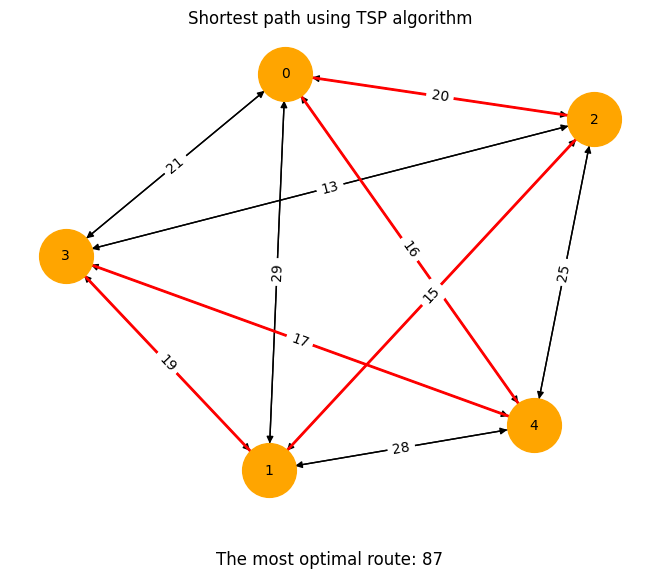

In [28]:
# Create the directed graph
g = nx.DiGraph()

# Add edges and their weights
edges = [(0, 1, {'weight': 29}), (0, 2, {'weight': 20}), (0, 3, {'weight': 21}), (0, 4, {'weight': 16}),
         (1, 0, {'weight': 29}), (1, 2, {'weight': 15}), (1, 3, {'weight': 19}), (1, 4, {'weight': 28}),
         (2, 0, {'weight': 20}), (2, 1, {'weight': 15}), (2, 3, {'weight': 13}), (2, 4, {'weight': 25}),
         (3, 0, {'weight': 21}), (3, 1, {'weight': 19}), (3, 2, {'weight': 13}), (3, 4, {'weight': 17}),
         (4, 0, {'weight': 16}), (4, 1, {'weight': 28}), (4, 2, {'weight': 25}), (4, 3, {'weight': 17})]

g.add_edges_from(edges)

# Define the correct path
correct_path = [0, 4, 3, 1, 2, 0]

# Draw the graph
pos = nx.spring_layout(g)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw(g, pos, with_labels=True, node_color='orange', node_size=1500, font_size=10)

# Draw the correct path
nx.draw_networkx_edges(g, pos, edgelist=[(correct_path[i], correct_path[i + 1]) for i in range(len(correct_path) - 1)], edge_color='red', width=2)

# Add edge labels
labels = nx.get_edge_attributes(g, 'weight')
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)

# Calculate the total cost of the red subgraph
red_subgraph_cost = sum(labels[edge] for edge in zip(correct_path[:-1], correct_path[1:]))

# Print the total cost of the red subgraph
plt.text(0.5, -0.1, f"The most optimal route: {red_subgraph_cost}", horizontalalignment='center', size = 12, verticalalignment='center', transform=plt.gca().transAxes)

# Show the plot
plt.title("Shortest path using TSP algorithm")
plt.show()
